<a href="https://colab.research.google.com/github/Romanchenko-RS/ML/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8_%D0%B4%D0%B5%D1%82%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD%D1%87%D0%B5%D0%BD%D0%BE_%D0%A0_%D0%A1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Импорт необходимых библиотек**

In [4]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

**Подготовка данных**

In [9]:
# Загружаем исходные данные
train = np.loadtxt('/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('/test.csv', delimiter=',', skiprows=1)

In [10]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

In [11]:
# приводим размерность к необходимому виду для обаботки
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

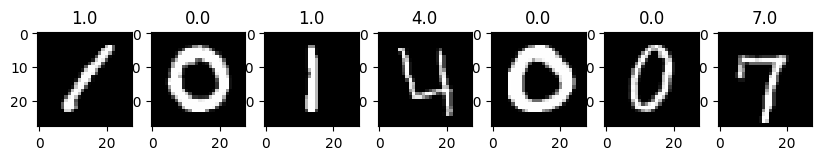

In [15]:
# Выведем исходные данные
fig = plt.figure(figsize=(10, 8))
for i, img in enumerate(train_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % train_label[i - 1])

**Работа с моделью**

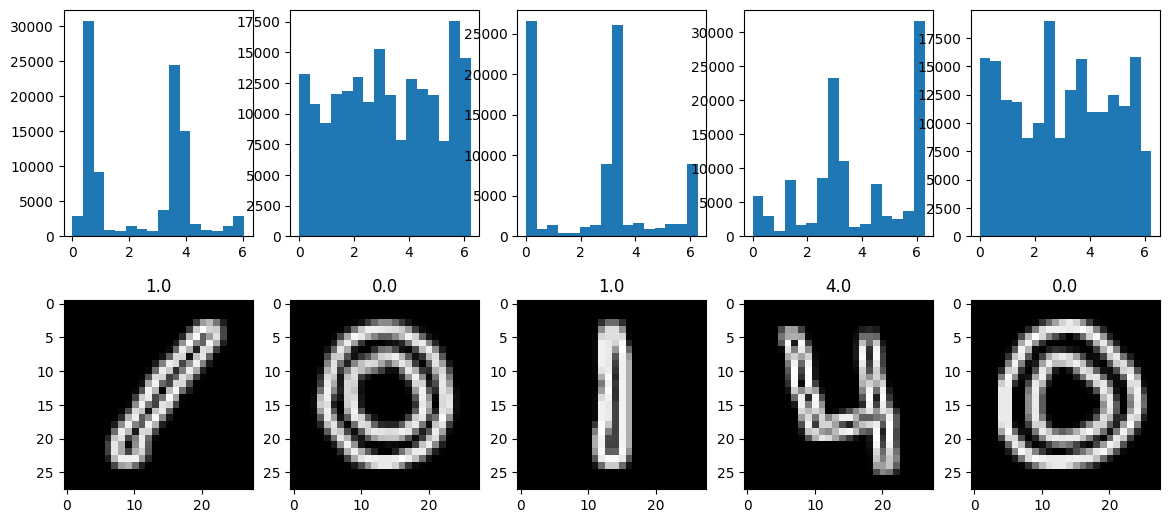

In [13]:
# Вычисляем X и Y составляющие градиента с помощью оператора Собеля
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

# Вычисляем угол и длину вектора градиента
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % train_label[i - 1])
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(), bins=16, weights=train_g[i - 1].flatten())

# Вычисляем гистограммы градиентов
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i], bins=16, range=(0., 2. * np.pi), weights=train_g[i])
    train_hist[i] = hist

test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i], bins=16, range=(0., 2. * np.pi), weights=test_g[i])
    test_hist[i] = hist

In [16]:
# Нормируем вектор гистограммы
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

# Разбиваем выборку на обучение и валидацию
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hist, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
test_hist = scaler.transform(test_hist)

In [24]:
# Обучение модели Random Forest
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(x_train, y_train)

# Прогнозирование на валидационной выборке
pred_val = clf.predict(x_val)

# Оценка качества модели
accuracy = accuracy_score(y_val, pred_val)
print('Accuracy: %s' % accuracy)

print(classification_report(y_val, pred_val))

print(confusion_matrix(y_val, pred_val))

Accuracy: 0.6363095238095238
              precision    recall  f1-score   support

         0.0       0.41      0.39      0.40       816
         1.0       0.97      0.96      0.96       909
         2.0       0.47      0.45      0.46       846
         3.0       0.64      0.66      0.65       937
         4.0       0.71      0.72      0.72       839
         5.0       0.61      0.65      0.63       702
         6.0       0.46      0.45      0.46       785
         7.0       0.86      0.79      0.82       893
         8.0       0.51      0.56      0.53       835
         9.0       0.68      0.68      0.68       838

    accuracy                           0.64      8400
   macro avg       0.63      0.63      0.63      8400
weighted avg       0.64      0.64      0.64      8400

[[315   5  70  34  29  16 131  14 164  38]
 [  3 870   2   0  22   0   1   7   0   4]
 [ 52   0 377 127   5 108  65  17  78  17]
 [ 25   0 109 619   0  96   9   4  69   6]
 [ 23  13  13   1 605   1  78  29   8  6

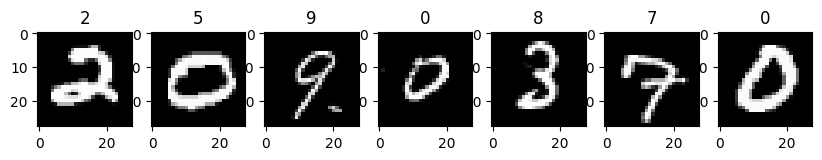

In [25]:
# Предсказания на тестовых данных
pred_test = clf.predict(test_hist)

# Визуализируем предсказания
fig = plt.figure(figsize=(10, 8))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % int(pred_test[i - 1]))

**Отправка файла на проверку**

In [27]:
with open('check50.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%d\n' % (i, int(p)))

# Печатаем первые несколько строк файла для проверки
!head check50.csv

ImageId,Label
1,2
2,5
3,9
4,0
5,8
6,7
7,0
8,3
9,3


Результат

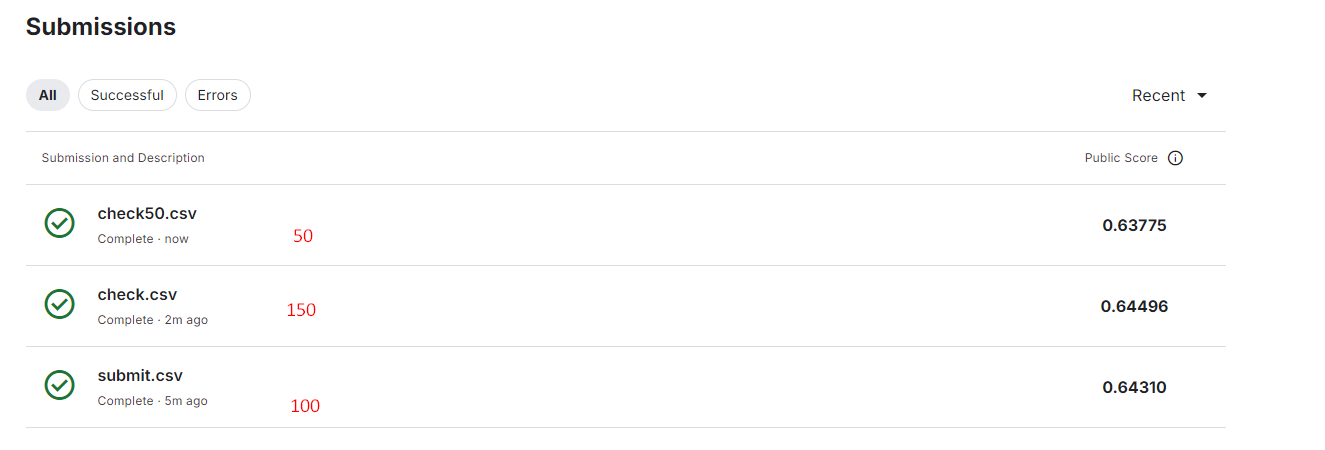

**Вывод**

Построил модель случайного леса и провеёл несколько вариаций с количеством деревьев: наилучшее качество показала модель, у которой было 150 деревьев, хотя модель со 100 деревьями показала себя незначительно хуже (разница в 0,3%), однако модель со 150 деревьями обучалась дольше.

Для улучшения качества предсказаний можно попытаться применить другие модели или даже ансамбли моделей.